## Example TU Wien Soil Moisture time series of stacked file

In this example we read and plot soil moisture time series using stacked files.

In [1]:
from veranda.io.stack import NcRasterStack
import xarray as xr
import netCDF4
import numpy as np

#For reading in filelist
import glob
import re
import pandas as pd
from datetime import datetime

#For timeseries plot
from equi7grid.equi7grid import Equi7Grid
import matplotlib.pyplot as plt

#For cartopy plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#TODO: check why xr.open_mfdataset does not work, e.g. parameters
#http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html
def build_inventory(path,datetime_format):
        """
        Builds dataframe containing filenames and timestamps for h28 type files.
        
        Returns      
        -------      
        inventory : pandas.DataFrame 
            filenames and timestamps    
        
        """
        path_combined = path
        
        file_list = [file for file in glob.glob(path_combined+"/*.nc")]
        
        fname = file_list[0]
        match = re.search('\d{8}', fname).span()
        
        filename_datetime_format = (match[0], match[0]+15, datetime_format)
        ts_list = list()
        for f in file_list:
            
            ts = f[filename_datetime_format[0]:filename_datetime_format[1]]
            ts = datetime.strptime(ts, filename_datetime_format[2])
            ts_list.append(ts)
        
        inventory = pd.DataFrame(index=pd.DatetimeIndex(ts_list),
        columns=['filepath'],
        data=file_list)
        
        return inventory

### With veranda

We can combine files or stacks into a single stack for time series plotting.

In [3]:
#set source directory
dir = '/home/leonard/Documents/TUWIEN/test_files/'
input_path = dir+'*.nc'

#reads all files in input path, needed to stack by time
ds_ver = xr.open_mfdataset(input_path)

#convert time to datetime
ds_ver['time'] = netCDF4.num2date(ds_ver['time'], "days since 1900-01-01 00:00:00",
                 only_use_cftime_datetimes=False)

In [4]:
#ALTERNATIVE working version, depends on build_inventory:
dir = '/home/leonard/Documents/TUWIEN/test_files/'
out_path = dir+'stacked/'

stack = NcRasterStack(mode='w')

datetime_format = "%Y%m%d_%H%M%S"
inventory = build_inventory(dir,datetime_format)
   
with NcRasterStack(inventory=inventory) as stack:
    ds_ver = stack.read(band='sm')
    
    
ds_ver = ds_ver.assign_coords({'time':ds_ver['time'].astype('datetime64[ns]')})
inventory = stack.write_netcdfs(ds_ver, out_path)
 

In [11]:
#FIXME: this does not work for some reason!
#stack all files in directory

#ds = xr.open_mfdataset(input_path) #FIXME: NcFile can't open this for some reason

# with NcRasterStack(mode='w') as stack:
#     inventory = stack.write_netcdfs(ds, dir)

# with NcRasterStack(inventory=inventory) as stack:
#     ts = stack.read(band='sm')
    
# from veranda.io.netcdf import NcFile
# ref_filepath = inventory[inventory.notnull()]['filepath'][0]

# netcdf = NcFile(ref_filepath, mode='r')

# with NcFile(ref_filepath, mode='r') as netcdf:
#     self.sref = netcdf.sref  <----- CANT READ THIS DATA
    #self.geotrans = netcdf.geotrans
    #self.metadata = netcdf.metadata
    #self.shape = (len(self.inventory), netcdf.shape[-2], netcdf.shape[-1])
    #self._dims = len(netcdf.shape)

### Visualization

#### Time series plot

Plot soil moisture over time.

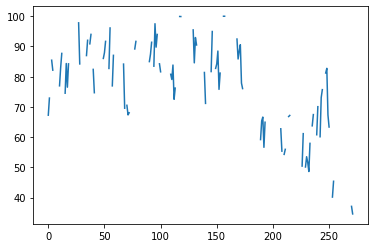

In [5]:
#define grid for plotting
e7_grid = Equi7Grid(500)

#location of sm source
lon,lat = 45.131913, 12.097916#44.5711, 11.5321
_, lon_i, lat_j = e7_grid.lonlat2ij_in_tile(lon, lat)

#or use index where max sm records not nan
sm_nan_sum = np.sum(~np.isnan(ds_ver['sm'].values),axis=0)
i,j = np.argwhere(sm_nan_sum==sm_nan_sum.max())[0]

 
#soil moisture time series
sm = ds_ver['sm'].values[:,i,j]

plt.plot(sm)

#### Plot map data

Plot soil moisture on a cartopy map.

In [6]:
def plot_map(img, extent, title='',vmin=None, vmax=None):
    # Equi7Grid - Europe
    central_meridian = 24.0
    latitude_of_origin = 53.0
    false_easting = 5837287.81977
    false_northing = 2121415.69617

    crs = ccrs.AzimuthalEquidistant(central_meridian, latitude_of_origin,
                                    false_easting, false_northing)

    fig = plt.figure(figsize=(14,12))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=crs, frameon=False)
    ax.patch.set_visible(False)
    ax.set_title(title)

    sc = ax.imshow(img, transform=crs, extent=extent,
                   vmin=vmin, vmax=vmax, origin='upper')

    ax.set_extent(extent, crs)

    countries_50m = cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_countries', '50m')
    ax.add_feature(countries_50m, facecolor='none', edgecolor='black')
    plt.colorbar(sc)

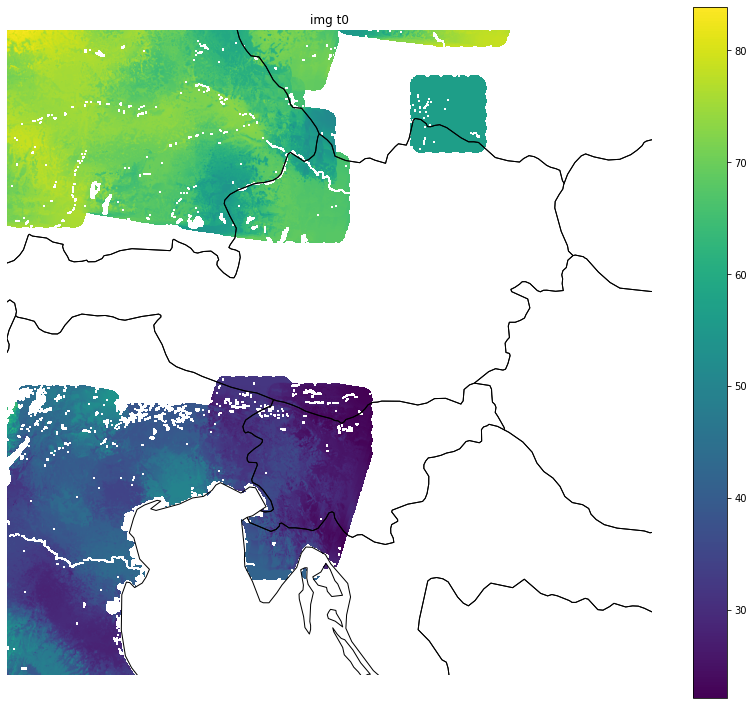

In [8]:
#define image source to be plotted
img = ds_ver['sm'].values[0,:,:]
title = 'img t0'

x = ds_ver.variables['x'][:]
y = ds_ver.variables['y'][:]
extent = [x.min(), x.max(), y.min(), y.max()]

plot_map(img, extent, title=title)

### With xarray

We can also read a single stack with xarray.

In [9]:
ds_xr = xr.open_mfdataset('/home/leonard/Documents/TUWIEN/test_files/*.nc')

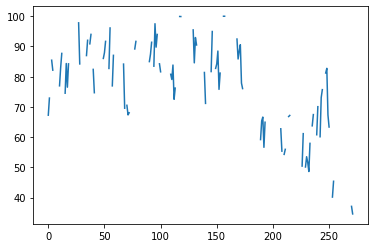

In [10]:
#define grid for plotting
e7_grid = Equi7Grid(500)

#location of sm source
lon,lat = 45.131913, 12.097916#44.5711, 11.5321
_, lon_i, lat_j = e7_grid.lonlat2ij_in_tile(lon, lat)

#or use index where max sm records not nan
sm_nan_sum = np.sum(~np.isnan(ds_ver['sm'].values),axis=0)
i,j = np.argwhere(sm_nan_sum==sm_nan_sum.max())[0]

#soil moisture time series
sm_xr = ds_xr['sm'].values[:,i,j]

plt.plot(sm_xr)

In [12]:
sm_xr

array([ 67.27    ,  72.93    ,        nan,  85.46    ,  82.159996,
              nan,        nan,  81.909996,        nan,        nan,
        76.979996,  82.93    ,  87.71    ,        nan,        nan,
        74.54    ,  84.36    ,  76.53    ,  84.25    ,        nan,
              nan,  79.43    ,        nan,        nan,        nan,
              nan,        nan,  97.82    ,  84.229996,        nan,
              nan,        nan, 100.      ,        nan,  86.99    ,
        92.049995,        nan,  90.869995,  94.      ,        nan,
        82.42    ,  74.7     ,        nan,  85.799995,        nan,
              nan,        nan,  97.36    ,        nan,  86.04    ,
        87.93    ,  91.689995,        nan,        nan,  82.729996,
        96.119995,        nan,  76.97    ,  87.07    ,        nan,
              nan,  83.06    ,        nan,        nan,        nan,
              nan,        nan,  84.17    ,  69.58    ,        nan,
        70.54    ,  67.36    ,  68.06    ,        nan,  82.759

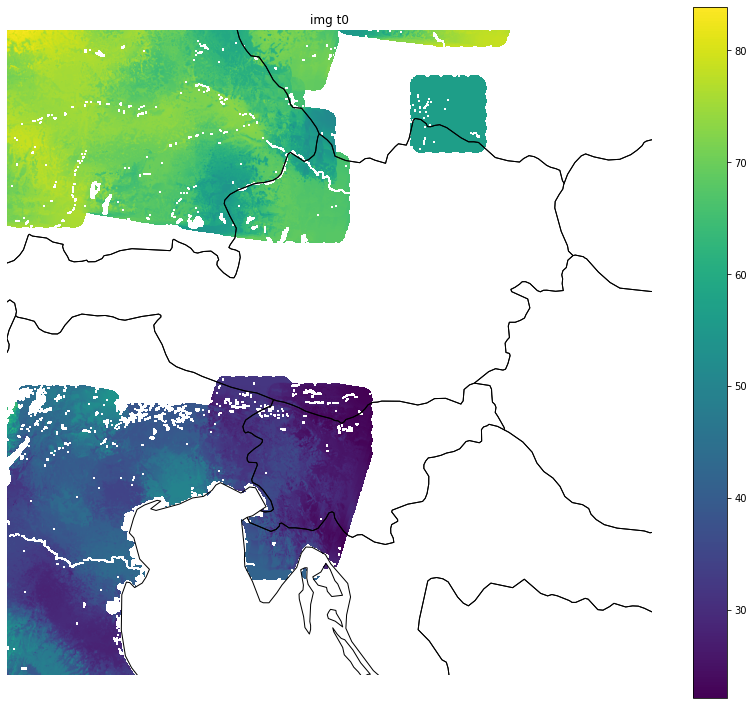

In [59]:
#define image source to be plotted
img = ds['sm'].values[0,:,:]
title = 'img t0'

x = ds.variables['x'][:]
y = ds.variables['y'][:]
extent = [x.min(), x.max(), y.min(), y.max()]

plot_map(img, extent, title=title)